# Heat transfer during dike cooling

In this notebook, we are interested in modeling heat transfer during the emplacement and subsequent cooling of dikes. In doing so, we are particularly interested in understanding the timescale for cooling within the dike itself and the magnitude of heating of the host rock into which a dike intruded.

This problem was dealt with nicely in an article published by Paul T. Delaney of the US Geological Survey:

Delaney, P.T. 1987. Heat transfer during emplacement and cooling of mafic dykes In Mafic dyke swarms. Edited by H.C. Halls and W.F. Fahrig. Geological Association of Canada, Special Paper 34, pp. 31-46.

## An analytical solution to transient heat conduction

Delaney (1987) formulates the problem by idealizing a dike as a tabular channel of infinite extent. Coordinates are based on the position of the dike wall with the $X$-direction being the direction orthogonal to the wall such that negative $X$ values are within the dike and positive $X$ values are in the host rock. The dike has a thickness $T$ and an initial temperature $\Theta_{mi}$ (subscript stands for magma initial). The host rock has an initial temperature $\Theta_{hi}$ and a thermal diffusivity $\kappa_h$.
> Conservation of energy for a motionless material undergoing one-dimensional heat transfer with no chemical reactions is (Carslaw and Jaeger, 1959, Ch. 1; Bird et al., 1960, Ch.10):
\begin{equation}
\rho C\frac{\partial\Theta}{\partial t} = \frac{\partial}{\partial X}k\frac{\partial\Theta}{\partial X}
\end{equation}
This equation states that the heat conducted into a unit volume minus the heat conducted out is equal to the accumulation of heat within the volume. The right-hand side of equation 1 is the gradient in heat flux, which is given by Fourier's Law, $Q = - k\partial\Theta/\partial X$ where $k$ is thermal conductivity; the left-hand side is the rate of accumulation of heat, where pC is heat capacity per unit volume. If k is constant, then:
\begin{equation}
\frac{\partial\Theta}{\partial t} = \kappa\frac{\partial^2\Theta}{\partial X^2}
\end{equation}
Thermal diffusivity, $\kappa = k/(pC)$, measures the ability of a material to conduct heat relative to its ability to accumulate heat.

> Generality and simplicity are gained by introducing non-dimensional temperature $\theta$, distance $x$, and time $\tau$:

> \begin{equation}
\theta = (\Theta-\Theta_{hi})/(\Theta_{mi}-\Theta_{hi})
\end{equation}

> \begin{equation}
x = X/(T/2)
\end{equation}

> \begin{equation}
\tau = t*\kappa_h/(T/2)^2
\end{equation}

Following this introduction, Delaney builds up to presenting the first and simplest whole-time solution. This solution neglects themal property constrasts between the host rock and dike (i.e. $\kappa_m/\kappa_h=1$). These thermal property contrasts can affect the maximum temperatures reached in the host rock and early cooling rates, but the influence is rather small. This whole-time solution is:

> \begin{equation}
\theta = \frac{1}{2}[erf\big(\frac{2+x}{\sqrt{4\tau}}\big)-erf\big(\frac{x}{\sqrt{4\tau}}\big)]
\end{equation}

Delaney also presents numerical solutions that incorporate the effects of the heat of crystallization, magma flow and the temperature dependance of thermal conductivity and diffusivity. In the application that we are exploring here, the cooling of a breccia dike emplaced within an impact crater, neither the heat of crystallization nor magma flow apply and therefore the analytical solution using transient heat conduction theory will work well for our analysis. 

## Implementing the whole-time solution

### Important some scientific Python libraries

In [1]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

### Define the function dike_cooling()

A function can be defined that returns the temperature at a given time and distance from the contact (within or outside of the dike) for a given initial dike temperature, initial host rock temperature, dike width and thermal diffusivity. This function calculates non-dimensional distance and time and then solves for non-dimensional temperature using the whole-time solution detailed above. The temperature of interest can then be extracted from the non-dimensional temperature using the specified intial temperatures.

In [2]:
def dike_cooling(t,distance_from_contact,temp_dike,temp_host,dike_width,kn):
    x_nd = distance_from_contact/(dike_width/2)
    tau_nd = t * kn/((dike_width/2.0)**2)
    temp_nd =  0.5 * (special.erf((2+x_nd)/np.sqrt(4*tau_nd)) - special.erf(x_nd/np.sqrt(4*tau_nd)))
    temp = temp_nd*(temp_dike-temp_host) + temp_host
    return temp

### Input parameters

In [3]:
dike1_temp = 800.0 #in Celcius
dike1_host_temp = 250.0 #in Celcius
dike1_width = 0.5 #in meters
dike1_kn = 7e-7 #thermal diffusivity (m^2/s)

### Plot temperature vs distance at a number of times

/Users/Laurentia/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


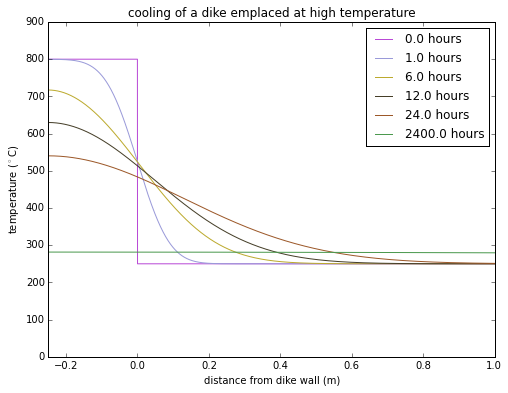

In [4]:
plt.figure(figsize=(8,6))

for time in [0.0,60*60,6*60*60,12*60*60,24*60*60,100*24*60*60]:

    temp = []
    distance = []
    
    for distance_from_contact in np.arange(-dike1_width/2,dike1_width*2,0.00001):
        temp_at_distance = dike_cooling(time,distance_from_contact,dike1_temp,dike1_host_temp,dike1_width,dike1_kn)
        temp.append(temp_at_distance)
        distance.append(distance_from_contact)
    plt.plot(distance,temp,c=np.random.rand(3,),label=str(time/60/60)+' hours')
        
plt.xlabel('distance from dike wall (m)')
plt.ylabel('temperature ($^\circ$C)')
plt.ylim((0,dike1_temp+100))
plt.xlim((-dike1_width/2,dike1_width*2))
plt.legend()
plt.title('cooling of a dike emplaced at high temperature')
plt.show()

### Plot temperature vs time at the center of the dike

/Users/Laurentia/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars


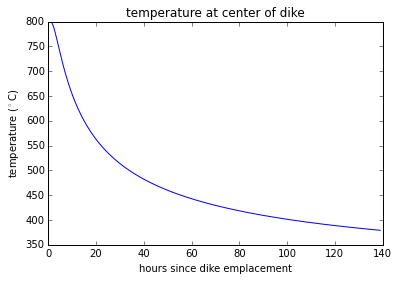

In [5]:
distance_from_contact = -dike1_width/2.0 #center of dike in meters
time = []
time_days = []
time_hours = []
temp = []

for t in range(0,500000,100):
    temp_at_t = dike_cooling(t,distance_from_contact,dike1_temp,dike1_host_temp,dike1_width,dike1_kn)
    temp.append(temp_at_t)
    time.append(t)
    time_hours.append(t/60.0/60.0)
    time_days.append(t/60.0/60.0/24.0)
    
plt.plot(time_hours,temp)
plt.xlabel('hours since dike emplacement')
plt.ylabel('temperature ($^\circ$C)')
plt.title('temperature at center of dike')
plt.show()

## Temperature dependence of thermal diffusivity

The above analysis does not incorporate the temperature-dependence of thermal diffusivity which is something that Delaney (1987) explores in some detail. Laser flash-analysis has enabled advances in measurements of thermal conductivity at elevated temperature since the work of Delaney (1987). Such from schist, granite and rhyolite were published by:

Whittington A. G., Hofmeister A. M., Nabelek P. I. (2009) Temperature-dependent thermal diffusivity of the Earth's crust and implications for magmatism. Nature 458:319–321

These data were similar between the three rock types and the following empirical fits were proposed by Whittington et al. (2009) for the temperature dependence of thermal diffusivity (in square millimetres per second) in the continental crust.

\begin{equation}
\kappa_{crust}(T<846K)=567.3/T-0.062
\end{equation}

\begin{equation}
\kappa_{crust}(T>846K)=0.732-0.000135T
\end{equation}

A next step for this analysis would be to incorporate this temperature dependence of thermal diffusivity into the model. Taking all of the data from Whittington et al. (2009) between 350 and 580ºC (chosen as interval of interest due to blocking temperature of magnetite) gives an average value of 7.1E-6 m$^2$/s (1$\sigma$ of .12) which is what is used in the analysis above.

### Plot the Whittington et al. (2009) temperature dependent empirical fit

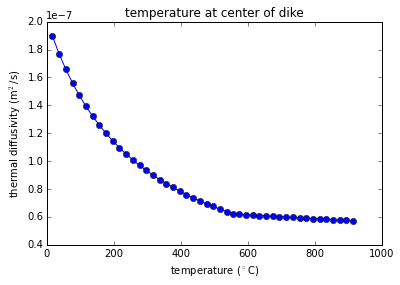

In [7]:
T = []
kappa = []

for temp in range(290,845,20):
    k = 567.3/temp - 0.062
    kappa.append(k*10**-7)
    T.append(temp-273)
for temp in range(848,1200,20):
    k = 0.732 - 0.000135*temp
    kappa.append(k*10**-7)
    T.append(temp-273)  

plt.plot(T,kappa,marker='o')
plt.ylabel('thermal diffusivity (m$^2$/s)')
plt.xlabel('temperature ($^\circ$C)')
plt.title('temperature at center of dike')
plt.show()

6.39853102401e-08


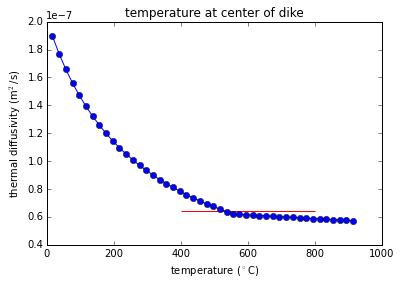

In [9]:
T_for_avg = []
kappa_for_avg = []

for temp in range(400+273,800+273):
    if temp > 846:
        k = 0.732 - 0.000135*temp
        kappa_for_avg.append(k*10**-7)
        T_for_avg.append(temp-273)  
    if temp < 846:
        k = 567.3/temp - 0.062
        kappa_for_avg.append(k*10**-7)
        T_for_avg.append(temp-273)
average_kappa = np.average(kappa_for_avg)
print(average_kappa)

plt.plot(T,kappa,marker='o')
plt.hlines(average_kappa,400,800,color='r')
plt.ylabel('thermal diffusivity (m$^2$/s)')
plt.xlabel('temperature ($^\circ$C)')
plt.title('temperature at center of dike')
plt.show()